in this file, automatic imbalance handling will be applied

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model selection and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           confusion_matrix, classification_report, average_precision_score)
# Calculate sample weights
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

# self-definced functions
from func import optimize_dtypes

# Load dataset

In [2]:
z_scaled = pd.read_csv('./data/z_scaled.csv', index_col=0)
print('dataset shape: ', z_scaled.shape)
print('5 sample:')
display(z_scaled.sample(5))
z_scaled = optimize_dtypes(z_scaled)

dataset shape:  (981694, 39)
5 sample:


,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,fulladdress_count_0_by_7,address_count_1,fulladdress_count_1,ssn_dob_count_30,ssn_count_30,...,fulladdress_homephone_count_7,fulladdress_homephone_count_0_by_30,ssn_dob_count_0_by_14,ssn_ssn_count_0_by_30,ssn_firstname_count_0_by_14,ssn_ssn_count_7,ssn_lastname_count_0_by_30,ssn_name_count_0_by_30,name_dob_count_0_by_30,fraud_label
270280,-0.101480,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.097490,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.172700,0.177126,0
701622,15.568083,14.364625,14.636471,5.008214,5.053083,-8.378168,4.057127,4.065077,-0.097490,-0.098988,...,6.422843,-8.842543,0.124092,0.174492,0.124638,-0.057567,0.173035,0.172700,0.177126,1
76682,-0.101480,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.097490,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.172700,0.177126,0
950203,-0.101480,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,-0.097490,-0.098988,...,-0.057383,0.171797,0.124092,0.174492,0.124638,-0.057567,0.173035,0.172700,0.177126,0
849879,1.465476,-0.088118,-0.078613,-0.072244,-0.066696,0.102735,-0.050525,-0.049118,1.893429,1.835858,...,-0.057383,-5.462165,0.124092,-5.357861,0.124638,-0.057567,-5.438476,-5.448475,-5.300636,0



OPTIMIZING DATA TYPES
----------------------------------------
Starting memory usage: 299.59 MB
Ending memory usage: 150.73 MB
Memory reduction: 49.7%


## split statistics
- 80% train, test set (X, y will be divided by train_test_split function) and
- 20% Out Of Time (OOT) set for validation of the best model

In [3]:
total = z_scaled.shape[0]
X = z_scaled.drop(['fraud_label'], axis=1)
y = z_scaled.fraud_label
X_oot = X[round(total*0.8):]
y_oot = y[round(total*0.8):]
X = X[0:round(total*0.8)]
y = y[0:round(total*0.8)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(f"Train set loaded: {X_train.shape}")
print(f"Test set loaded: {X_test.shape}")
print(f"OOT set loaded: {X_oot.shape}")
print("check length sum euqals to original length: ",len(y_train)+len(y_test)+len(y_oot)==len(z_scaled.fraud_label))
print(f"Fraud rate in train: {y_train.mean()*100:.2f}%")

Train set loaded: (549748, 38)
Test set loaded: (235607, 38)
OOT set loaded: (196339, 38)
check length sum euqals to original length:  True
Fraud rate in train: 1.44%


In [4]:
del z_scaled

# Build and Compare Baseline Models

In [5]:
# First, calculate the class weight ratio if needed
pos_class_ratio = y_train.sum() / len(y_train)  # fraud rate
neg_pos_ratio = (1 - pos_class_ratio) / pos_class_ratio  # for scale_pos_weight

baseline_models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight='balanced'  # Automatically balances classes
    ),
    
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'  # Automatically balances classes
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1,
        class_weight='balanced'  # Automatically balances classes
    ),
    
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        random_state=42
        # No built-in class_weight, but you can use sample_weight during fit
        # or adjust the init parameter
    ),
    
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        max_iter=1000, 
        random_state=42
        # No built-in class_weight parameter
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss',
        scale_pos_weight=neg_pos_ratio  # Balances by scaling positive class
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=100, 
        random_state=42, 
        verbosity=-1,
        is_unbalance=True  # Handles imbalanced data automatically
        # OR use: scale_pos_weight=neg_pos_ratio
    )
}

In [6]:
baseline_results = {}

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    # Train model
    if isinstance(model, GradientBoostingClassifier):
        sample_weights = compute_sample_weight('balanced', y_train)
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    baseline_results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba),
        'train_time': time.time() - start_time
    }
    
    print(f"ROC-AUC: {baseline_results[name]['roc_auc']:.4f}")
    print(f"F1 Score: {baseline_results[name]['f1']:.4f}")
    print(f"Training time: {baseline_results[name]['train_time']:.2f} seconds")

# Display baseline results
baseline_df = pd.DataFrame(baseline_results).T
print("\nBaseline Model Comparison:")
print(baseline_df.round(4))


Training Logistic Regression...
ROC-AUC: 0.7664
F1 Score: 0.3990
Training time: 4.06 seconds

Training Decision Tree...
ROC-AUC: 0.7237
F1 Score: 0.4398
Training time: 0.89 seconds

Training Random Forest...
ROC-AUC: 0.7448
F1 Score: 0.4679
Training time: 3.82 seconds

Training Gradient Boosting...
ROC-AUC: 0.7708
F1 Score: 0.4730
Training time: 17.33 seconds

Training Neural Network...
ROC-AUC: 0.7657
F1 Score: 0.6250
Training time: 47.68 seconds

Training XGBoost...
ROC-AUC: 0.7674
F1 Score: 0.4735
Training time: 1.19 seconds

Training LightGBM...
ROC-AUC: 0.7667
F1 Score: 0.4394
Training time: 1.63 seconds

Baseline Model Comparison:
                                                                 model  \
Logistic Regression  LogisticRegression(class_weight='balanced', ma...   
Decision Tree        DecisionTreeClassifier(class_weight='balanced'...   
Random Forest        (DecisionTreeClassifier(max_features='sqrt', r...   
Gradient Boosting    ([DecisionTreeRegressor(criterion='fr

In [9]:
fraud_weights = {
        'recall': 0.35,       # Most important - catch fraud cases
        'f1': 0.25,           # Balance of precision and recall
        'precision': 0.15,    # Avoid too many false alarms
        'roc_auc': 0.15,      # Overall discrimination ability
        'avg_precision': 0.10 # Performance across thresholds
    }

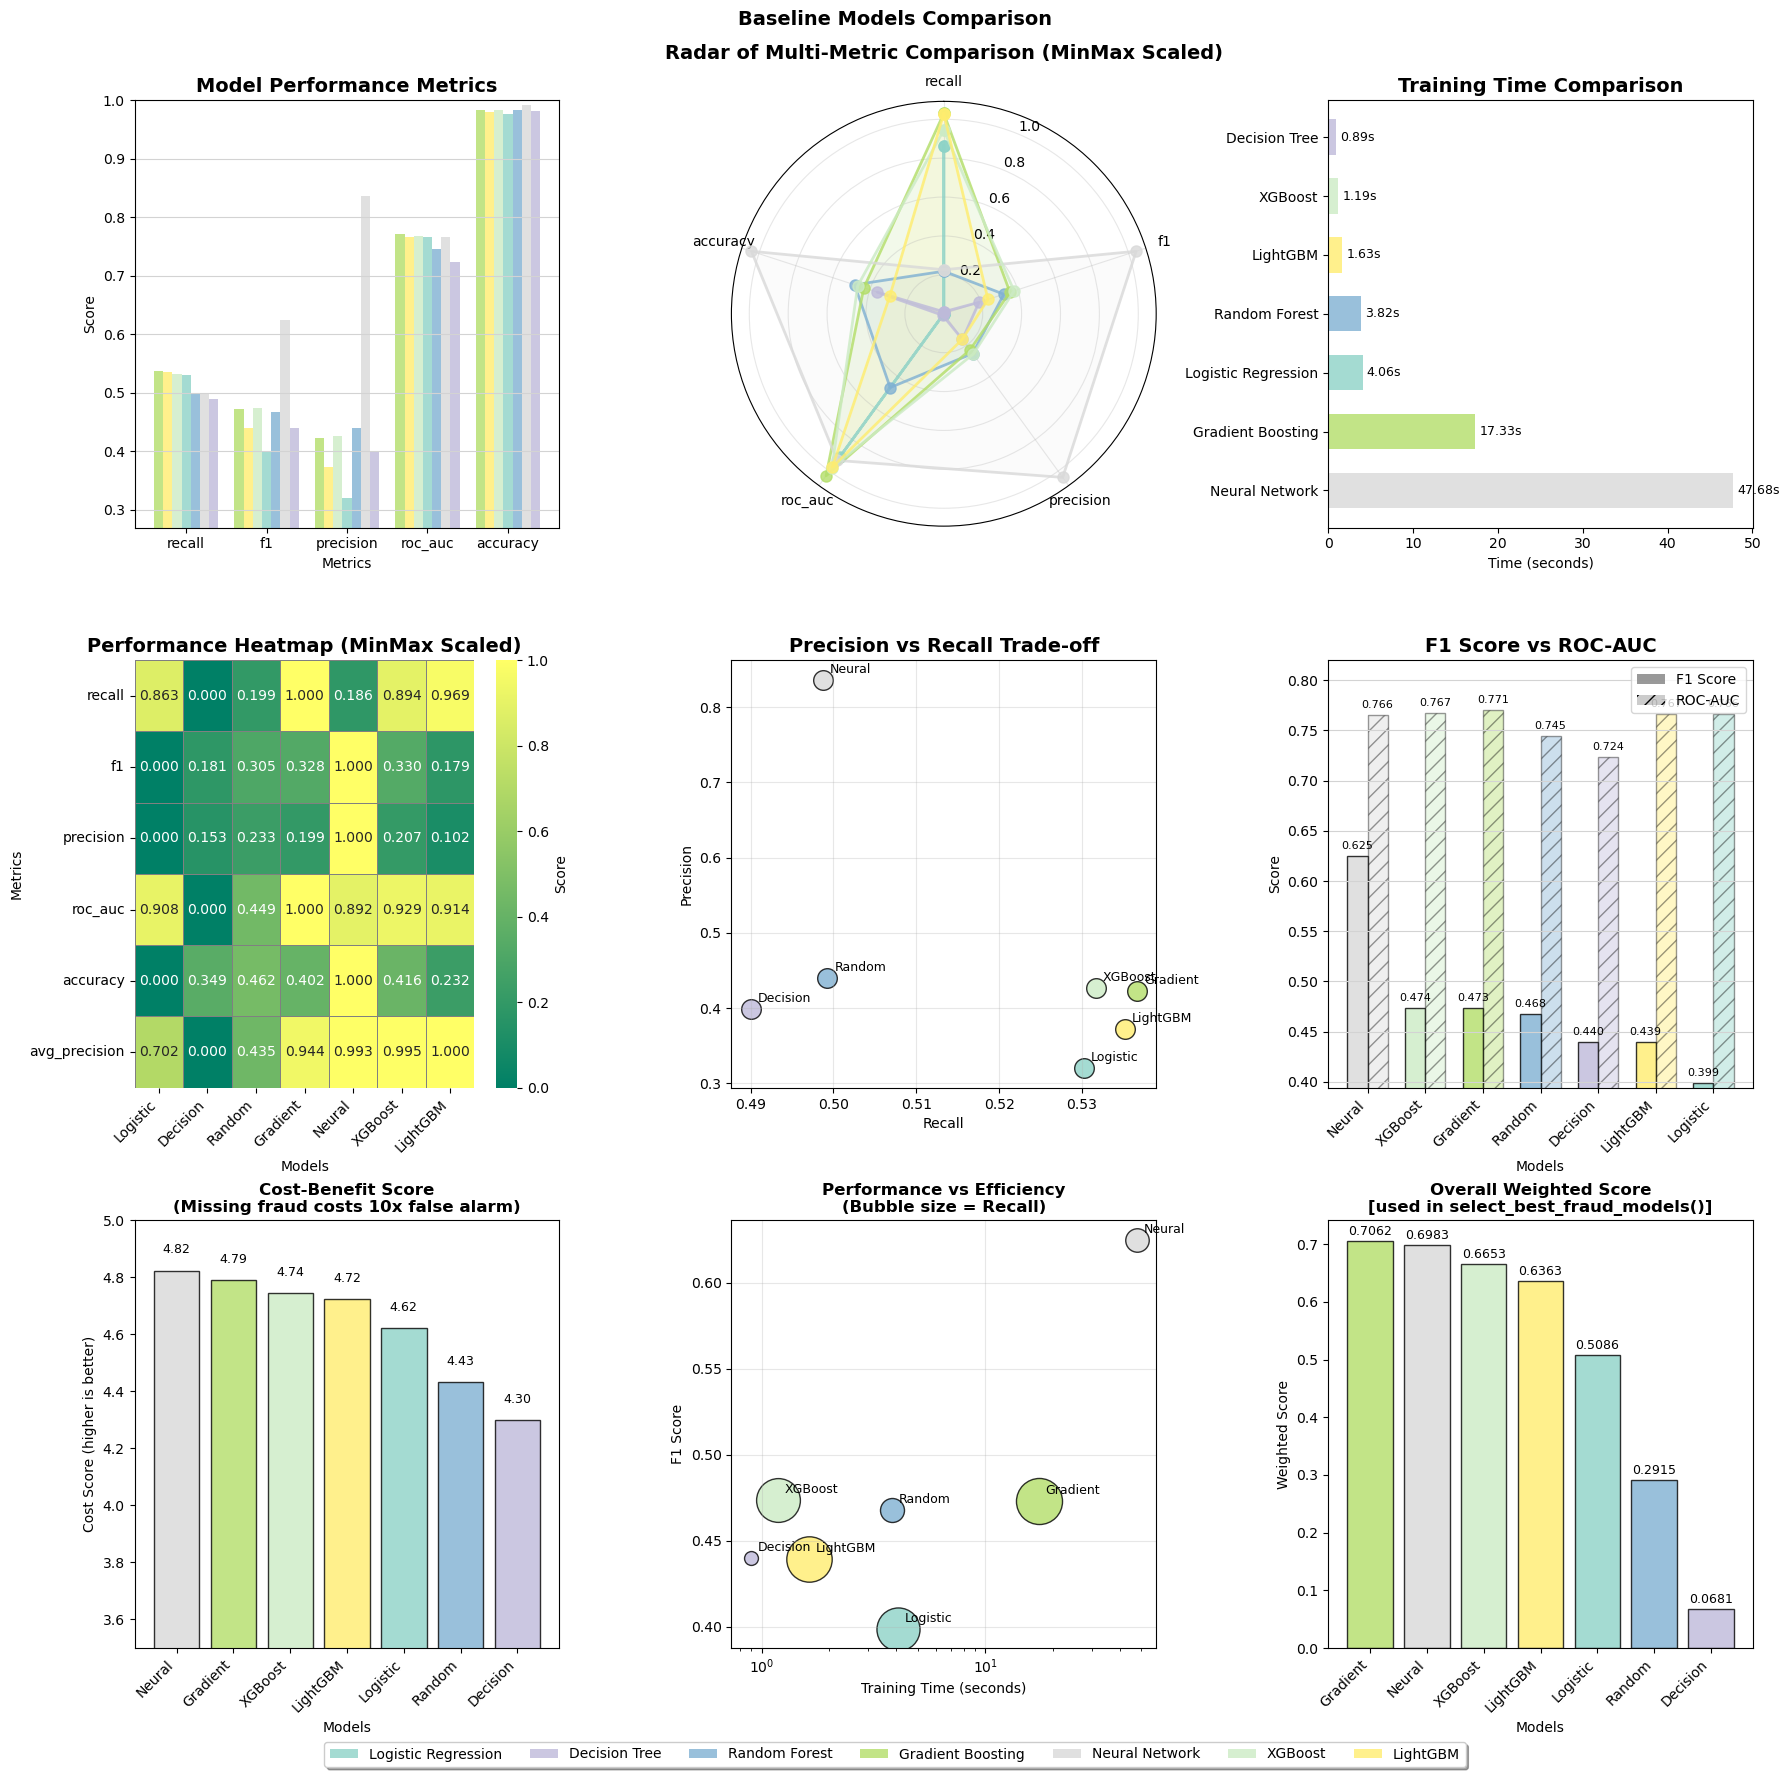

In [10]:
from func import plot_model_comparison
plot_model_comparison(baseline_df, weights = fraud_weights, top_n=3, 
                      figsize=(18, 18), figsave=False, figtitle = 'Baseline Models Comparison (auto Imbalance Handled)')

After comparing baseline models with and without automatic imbalance handling, the results show that while recall slightly improved, all other key metrics—including precision, F1-score, ROC-AUC, average precision, and cost-benefit score—declined when imbalance was addressed. Given that fraud detection requires both high recall and precision to minimize costly false positives and false negatives, the models without imbalance handling performed more effectively overall. Therefore, further optimization should focus on the original model setup without imbalance adjustments.